# Simple Individual Data Generation Example
For the individual data generation, the probability to have a true positive label is dependant on the previous predictions for the individual. In the simple generator, points can either be sampled from the positive or negative cluster and the number of previous positive predictions defines the probability for a point to be sampled from one of the two clusters. 

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from aif360.algorithms.inprocessing import PrejudiceRemover

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.naive_individual_data_generator import DataGenerator as IndDataGenSim
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

Import error: No module named 'tensorflow'


In [2]:
# The helper class is necessary to use sklearn with the ltf framework.
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)   

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# This is the data genarator used for sampling new data points.
# Individual features are generated form either the positive or the negative cluster from two gaussians
# with different mean and covariance matrix. Details about the generator are described in chapter 2.0.
# The negative cluster is generated with a much larger variance.
generator = IndDataGenSim(mean_pos=[0, 1],
                          mean_neg=[15, 13],
                          cov_neg=[[7, 0], [0, 6]],
                          num_positive_label=100,
                          num_negative_label=100,
                          discrimination_factor=.9)

In [5]:
# the metric evaluated at each time step t
metric = AifLongTermMetric()

In [6]:
# the decision function
clf = CLF(LinearSVC())

## Unconstrained Example
First, the unconstrained classifier is evaluated. The colored area represents the data generating decision boundary. Individuals in the read colored part have a negative label ($y=0$) and individuals in the white area a positive label ($y=1$).

The plot on the ride hand site is called *base line data* and refers to the data generated under the assumption, that all previous predictions were positive.

The green line is the decision boundary learned by the classifier. Green points are assigned an positive prediction and red points on negative prediction. Decision boundaries are the same in both the true and the baseline plot.

The classifier is only trained at the beginning when the data is initialized. An example where the classifier is retrained can be found in chapter 2.5.

In this example, the points are perfectly separable using a straight line and hence there are no miss predictions.

In [7]:
# the long term ploter
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 20], y_lim=[-1, 20])

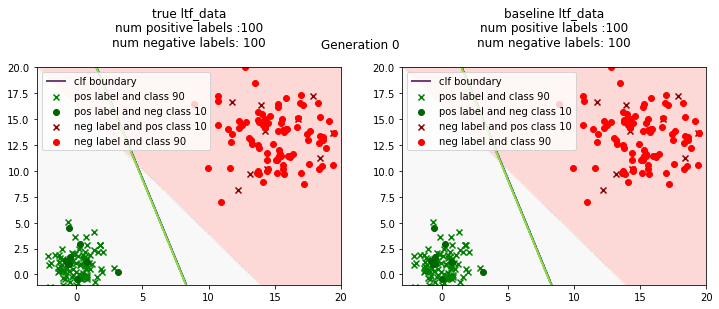

In [8]:
# initialize the data and plot the first generation
l.init_data()
l.plot_generation()

From a static point of view, this decision boundary could be interpreted as being fair. It does not make any errors and therefore all error based metrics would be satisfied. Additionally, similar data points are also treated the same, therefore even some individually based metrics are satisfied. Only disparate impact would be violated with a common threshold of 0.8:

$$\frac{P(\hat{y}=1 | a=1)}{P(\hat{y}=1 | a=0)}=\frac{0.9}{0.1}=0.11$$

Things change, when the dynamics are considered. Now, 20 generations are run and results plotted at the end.

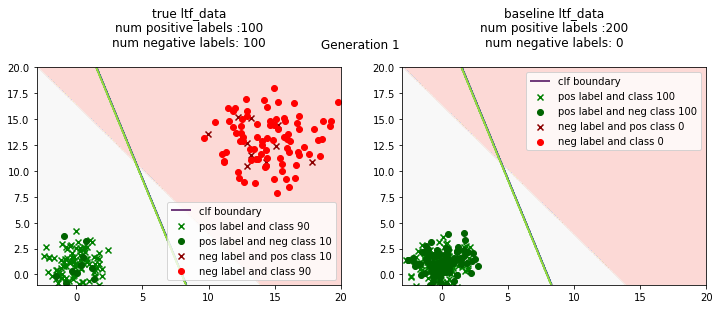

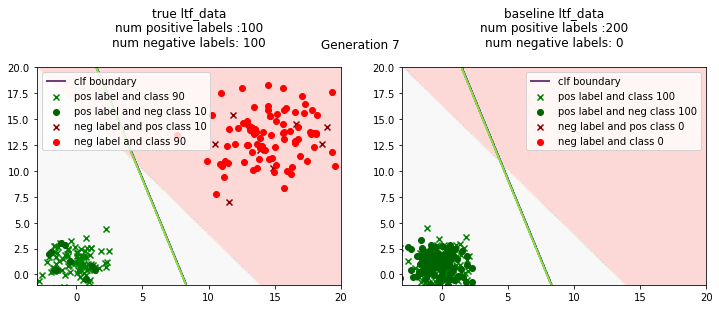

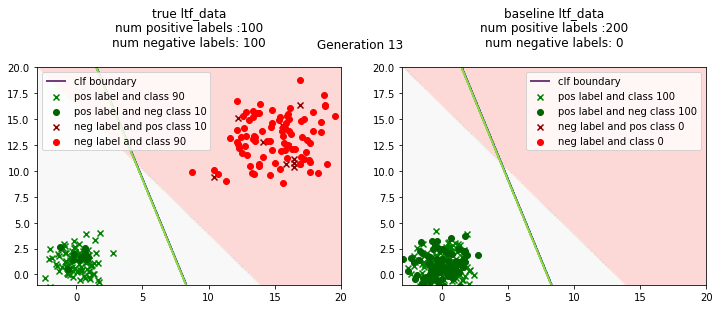

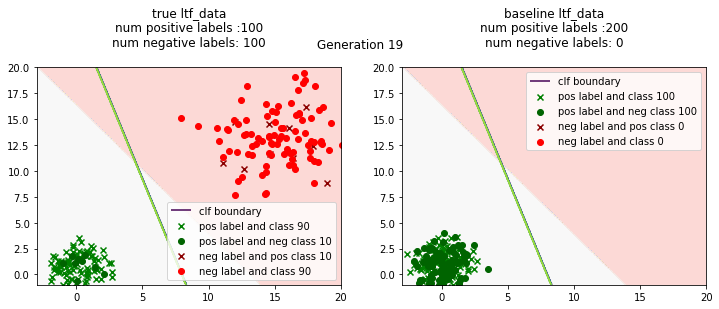

In [9]:
# Run 20 generations and plot the resultig data every 6th iteration
for i in range(20):

    l.run_generation()
    l.run_baseline_generation()
    if i %6 == 0:
        l.plot_generation()

After 20 generations, the true data still has the same characteristics (the same number of individuals in every category). Contrary, in the baseline data all individuals are positive since the first generation. Due to the simple data generation process (individuals simply jump between being sampled from positive or negative cluster) the error rates do not increase in the baseline case although the learned decision boundary does not match the true decision boundary perfectly. This will not be the case in the following examples anymore.

Finally, the fact that all individuals are true positive after one generation would also not be realistic in a real world scenario and is only used for visualization here.

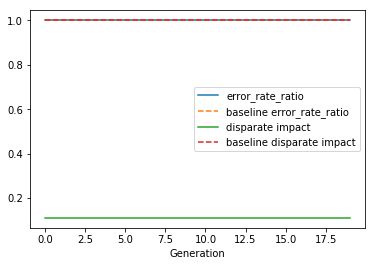

In [10]:
# plot the metrics over all generations
l.plot_ltf(["error_rate_ratio", "disparate impact"])

In the plot, the decision function does not have any long term impact, since the metrics are constant over time.
While the error rates are always perfect, disparate impact is only satisfied in the baseline case.

## Constrained Example
Next, the decision function is assumed to have a constraint. The decision function used here is a toy function, simulations with a true decision function are performed in chapter 2.5.

Note, that the toy decision function might also have been learned by a fair classifier.

In [11]:
# the fair decision function is ....
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

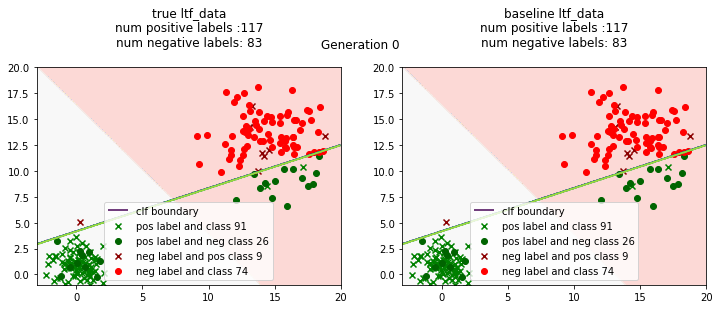

In [12]:
clf = FairCLF()

l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 20], y_lim=[-1, 20])

l.init_data()
l.plot_generation()

The data is generated in the same way as before, but now the "learned" decision function is not really close to the data generating function. Due to this some negative labeled individuals are assigned a positive prediction. These individuals will therefore jump to the positive cluster in the next generation. Because negative individuals are sampled from the same mean all individuals will jump to the positive cluster in the long term.

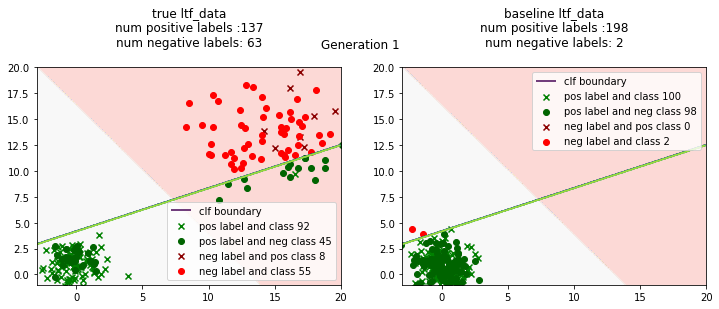

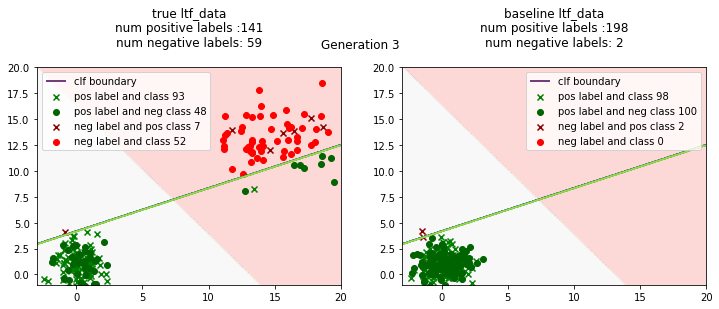

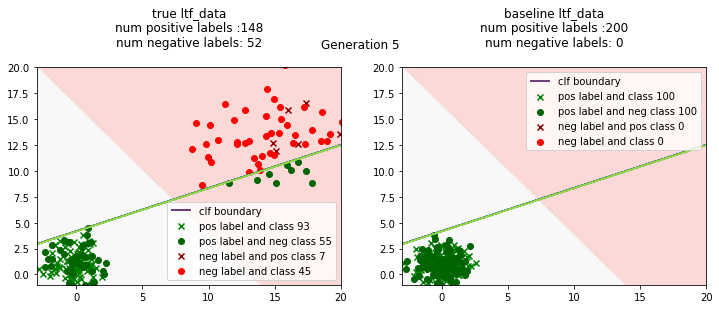

In [13]:
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

After 20 generation all individuals are positive labeled in the baseline data again, but contrary to the previous example the number in the true data also increased.

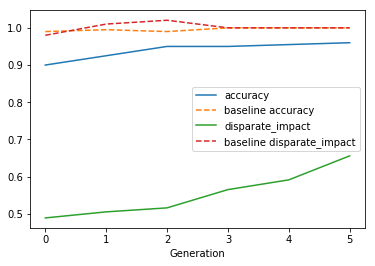

In [14]:
l.plot_ltf(metric._metrics)

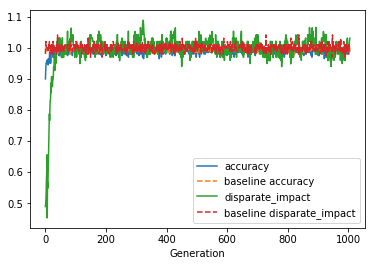

In [15]:
# run the simmuation for 1000 generation
l.run(1000)
l.plot_ltf(metric._metrics)

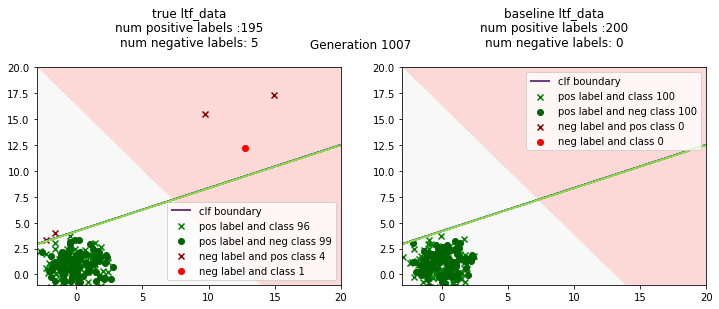

In [16]:
l.plot_generation()

After 1000 generation, the number of positive labeled individuals almost reached the same level for true and baseline data.